In [2]:
#Installing the pytorch version
!pip install torch torchvision


In [30]:
#Installing the required dependencies
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [32]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading QMNIST dataset
dataset_train = torchvision.datasets.QMNIST(root="./data", train=True, download=True, transform=transform)
dataset_test = torchvision.datasets.QMNIST(root="./data", train=False, download=True, transform=transform)

# Creating data loaders
loader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

print(f"Total training images available: {len(dataset_train)}")
print(f"Total testing images available: {len(dataset_test)}")


Total training images available: 60000
Total testing images available: 60000


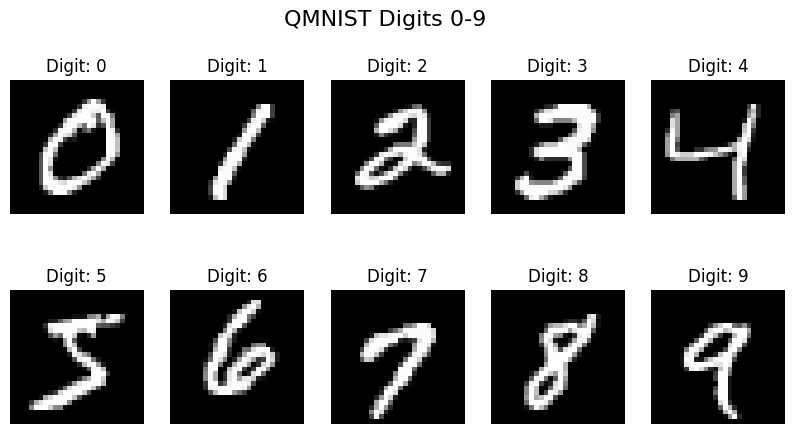

In [34]:
# plotting digits 0-9 from the QMNIST dataset
def plot_digits():
    digit_samples = {}

    # Collecting one sample per digit 
    for image, label in dataset_train:
        if label not in digit_samples:
            digit_samples[label] = image
        if len(digit_samples) == 10:  # Stop when all digits are collected
            break

    # Plot the digits
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle("QMNIST Digits 0-9", fontsize=16)

    for ax, digit in zip(axes.flat, range(10)):
        ax.imshow(digit_samples[digit].squeeze(), cmap='gray')
        ax.set_title(f"Digit: {digit}")
        ax.axis('off')

    plt.show()

# Call the function to display the images
plot_digits()

In [46]:
# BASE MODEL
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiate the model
cnn_model = SimpleCNN()

# Define loss function and opt_function
criterion = nn.CrossEntropyLoss()
opt_function = optim.Adam(cnn_model.parameters(), lr=0.001)


In [48]:
# TRAINING AND EVALUATION(BASE MODEL)
epochs_count = 10
loss_record_train, loss_record_test = [], []
acc_record_train, acc_record_test = [], []

for epoch in range(epochs_count):
    cnn_model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in loader_train:
        opt_function.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        opt_function.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    loss_record_train.append(train_loss / len(loader_train))
    acc_record_train.append(train_accuracy)

    cnn_model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader_test:
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    loss_record_test.append(test_loss / len(loader_test))
    acc_record_test.append(test_accuracy)

    # Corrected print statement
    print(f"Epoch {epoch + 1} out of {epochs_count}: "
          f"Training loss: {train_loss / len(loader_train):.4f}, Training Accuracy: {train_accuracy:.4f}, "
          f"Test loss: {test_loss / len(loader_test):.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1 out of 10: Training loss: 0.1657, Training Accuracy: 0.9482, Test loss: 0.0611, Test Accuracy: 0.9808
Epoch 2 out of 10: Training loss: 0.0472, Training Accuracy: 0.9850, Test loss: 0.0531, Test Accuracy: 0.9833
Epoch 3 out of 10: Training loss: 0.0313, Training Accuracy: 0.9906, Test loss: 0.0433, Test Accuracy: 0.9861
Epoch 4 out of 10: Training loss: 0.0236, Training Accuracy: 0.9922, Test loss: 0.0366, Test Accuracy: 0.9880
Epoch 5 out of 10: Training loss: 0.0176, Training Accuracy: 0.9947, Test loss: 0.0319, Test Accuracy: 0.9902
Epoch 6 out of 10: Training loss: 0.0145, Training Accuracy: 0.9952, Test loss: 0.0478, Test Accuracy: 0.9883
Epoch 7 out of 10: Training loss: 0.0122, Training Accuracy: 0.9962, Test loss: 0.0433, Test Accuracy: 0.9890
Epoch 8 out of 10: Training loss: 0.0085, Training Accuracy: 0.9972, Test loss: 0.0460, Test Accuracy: 0.9899
Epoch 9 out of 10: Training loss: 0.0086, Training Accuracy: 0.9971, Test loss: 0.0476, Test Accuracy: 0.9884
Epoch 10 o

In [49]:
# TUNED MODEL
class TunedCNN(nn.Module):
    def __init__(self):
        super(TunedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Instantiating the tuned model
tuned_model = TunedCNN()

# Defining loss function and optimizer function with a smaller learning rate
criterion_tuned = nn.CrossEntropyLoss()
opt_function_tuned = optim.Adam(tuned_model.parameters(), lr=0.0005)


In [50]:
# TRAINING AND EVALUATION (TUNED MODEL)
epochs_count = 10
loss_record_train_tuned, loss_record_test_tuned = [], []
acc_record_train_tuned, acc_record_test_tuned = [], []

for epoch in range(epochs_count):
    tuned_model.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in loader_train:
        opt_function_tuned.zero_grad()
        outputs = tuned_model(images)
        loss = criterion_tuned(outputs, labels)
        loss.backward()
        opt_function_tuned.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    loss_record_train_tuned.append(train_loss / len(loader_train))
    acc_record_train_tuned.append(train_accuracy)

    tuned_model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader_test:
            outputs = tuned_model(images)
            loss = criterion_tuned(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    loss_record_test_tuned.append(test_loss / len(loader_test))
    acc_record_test_tuned.append(test_accuracy)

    # Corrected print statement
    print(f"Epoch {epoch + 1} out of {epochs_count}: "
          f"Training loss: {train_loss / len(loader_train):.4f}, Training Accuracy: {train_accuracy:.4f}, "
          f"Test loss: {test_loss / len(loader_test):.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1 out of 10: Training loss: 0.1243, Training Accuracy: 0.9614, Test loss: 0.0459, Test Accuracy: 0.9859
Epoch 2 out of 10: Training loss: 0.0534, Training Accuracy: 0.9833, Test loss: 0.0336, Test Accuracy: 0.9893
Epoch 3 out of 10: Training loss: 0.0434, Training Accuracy: 0.9870, Test loss: 0.0352, Test Accuracy: 0.9898
Epoch 4 out of 10: Training loss: 0.0322, Training Accuracy: 0.9903, Test loss: 0.0404, Test Accuracy: 0.9893
Epoch 5 out of 10: Training loss: 0.0300, Training Accuracy: 0.9910, Test loss: 0.0390, Test Accuracy: 0.9900
Epoch 6 out of 10: Training loss: 0.0266, Training Accuracy: 0.9918, Test loss: 0.0394, Test Accuracy: 0.9895
Epoch 7 out of 10: Training loss: 0.0226, Training Accuracy: 0.9931, Test loss: 0.0384, Test Accuracy: 0.9907
Epoch 8 out of 10: Training loss: 0.0192, Training Accuracy: 0.9943, Test loss: 0.0477, Test Accuracy: 0.9886
Epoch 9 out of 10: Training loss: 0.0190, Training Accuracy: 0.9943, Test loss: 0.0411, Test Accuracy: 0.9909
Epoch 10 o

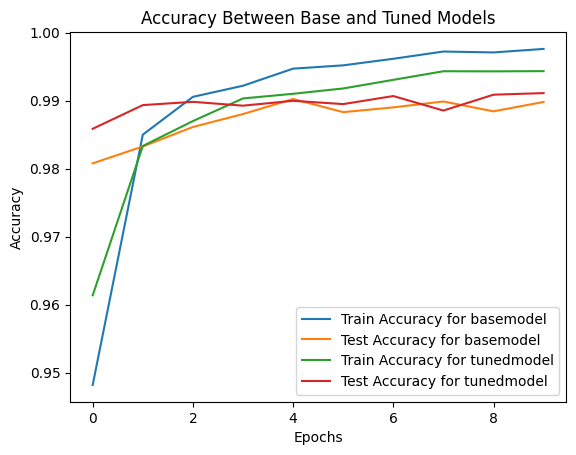

Basemodel Test Accuracy: 0.9898166666666667
Tunedmodel Test Accuracy: 0.9911166666666666


In [54]:
# Plotting the training and test accuracy of both models
import matplotlib.pyplot as plt

# Base Model Accuracy
plt.plot(acc_record_train, label="Train Accuracy for basemodel")
plt.plot(acc_record_test, label="Test Accuracy for basemodel")

# Tuned Model Accuracy
plt.plot(acc_record_train_tuned, label="Train Accuracy for tunedmodel")
plt.plot(acc_record_test_tuned, label="Test Accuracy for tunedmodel")

plt.title("Accuracy Between Base and Tuned Models")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


print("Basemodel Test Accuracy:", acc_record_test[-1])
print("Tunedmodel Test Accuracy:", acc_record_test_tuned[-1])


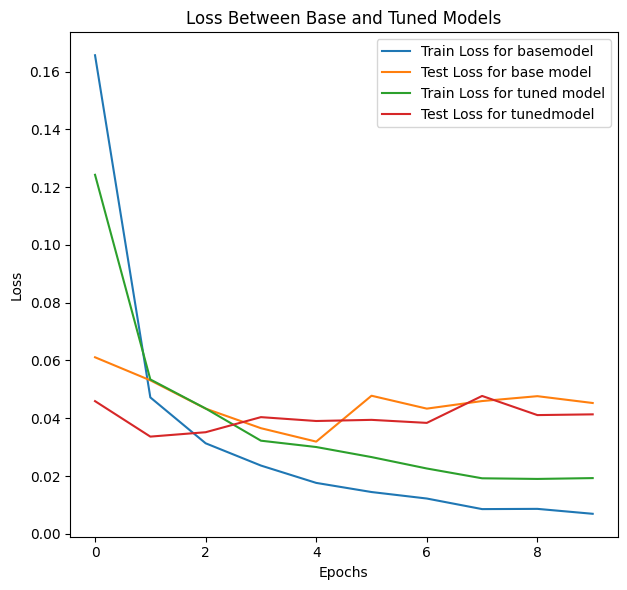

Basemodel Test Loss: 0.04528041609072259
Tunedmodel Test Loss: 0.04134952649084561


In [56]:


# Plotting both accuracy and loss for the Base Model and Tuned Model

# Accuracy Plot
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss_record_train, label="Train Loss for basemodel")
plt.plot(loss_record_test, label="Test Loss for base model")
plt.plot(loss_record_train_tuned, label="Train Loss for tuned model")
plt.plot(loss_record_test_tuned, label="Test Loss for tunedmodel")
plt.title("Loss Between Base and Tuned Models")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display both plots
plt.tight_layout()
plt.show()


print("Basemodel Test Loss:", loss_record_test[-1])
print("Tunedmodel Test Loss:", loss_record_test_tuned[-1])


Basemodel metrics inlcudes Precision: 0.9898, Recall: 0.9898, F1 Score: 0.9898


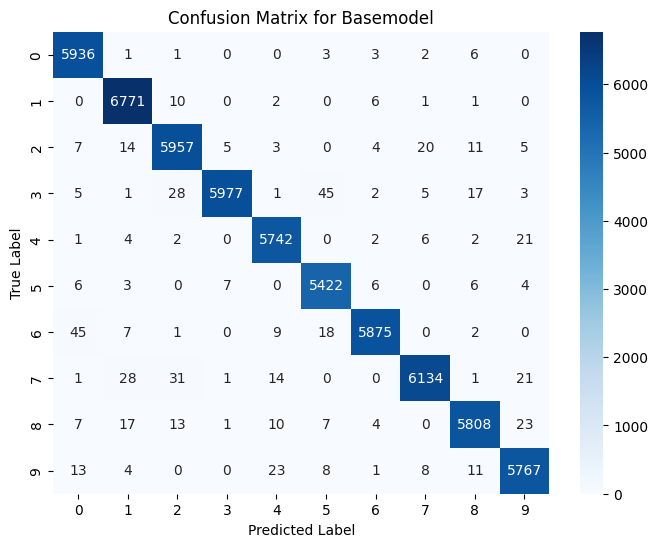

Tunedmodel metrics includes Precision: 0.9911, Recall: 0.9911, F1 Score: 0.9911


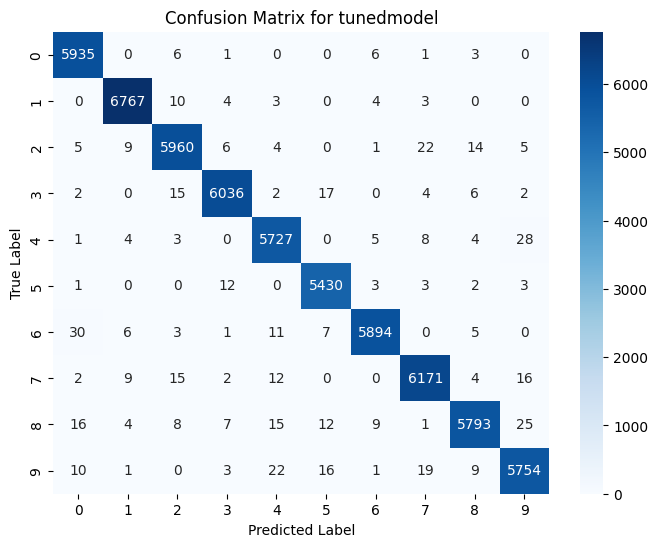

In [58]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculating precision, recall, F1 score, and confusion matrix
def calculate_metrics(model, data_loader):
    model.eval()  
    all_labels = []
    all_preds = []

    with torch.no_grad():  
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Converting lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Calculate precision, recall, f1 score, and confusion matrix
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return precision, recall, f1, conf_matrix

# Evaluating Base Model
cnn_model_precision, cnn_model_recall, cnn_model_f1, cnn_model_conf_matrix = calculate_metrics(cnn_model, loader_test)

# Printing Metrics for Basemodel
print(f"Basemodel metrics inlcudes Precision: {cnn_model_precision:.4f}, Recall: {cnn_model_recall:.4f}, F1 Score: {cnn_model_f1:.4f}")

# Plotting Confusion Matrix for Basemodel
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_model_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("Confusion Matrix for Basemodel")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Evaluating Tuned Model
tuned_model_precision, tuned_model_recall, tuned_model_f1, tuned_model_conf_matrix = calculate_metrics(tuned_model, loader_test)

# Printing Metrics for Tuned Model
print(f"Tunedmodel metrics includes Precision: {tuned_model_precision:.4f}, Recall: {tuned_model_recall:.4f}, F1 Score: {tuned_model_f1:.4f}")

# Plotting Confusion Matrix for Tuned Model
plt.figure(figsize=(8, 6))
sns.heatmap(tuned_model_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title("Confusion Matrix for tunedmodel")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


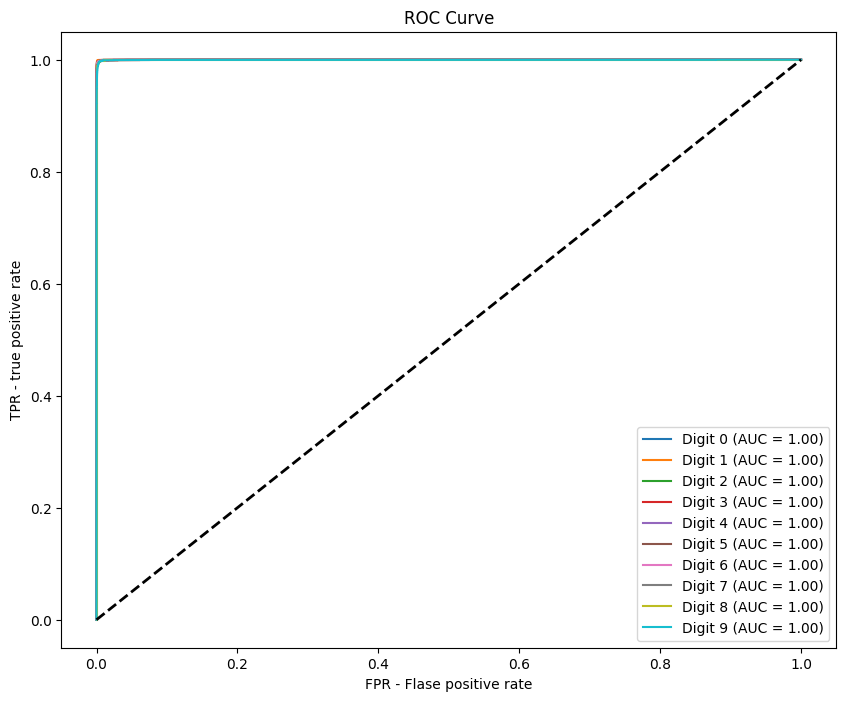

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# computing ROC curve and AUC score
def plot_roc_curve(model, dataloader, num_classes=10):
    model.eval()
    y_true, y_score = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.numpy())
            y_score.extend(probs.numpy())

    # Converting labels to one-hot encoding
    y_true = label_binarize(y_true, classes=np.arange(num_classes))
    y_score = np.array(y_score)

    # Plotting ROC curve for each digit
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Digit {i} (AUC = {roc_auc:.2f})")

    # Plotting the diagonal line
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    
    plt.xlabel("FPR - Flase positive rate")
    plt.ylabel("TPR - true positive rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Call function to plot ROC curves
plot_roc_curve(tuned_model, loader_test)


In [ ]:
# The base model has first layer with 32 filters and second layer with 64 filters, with 128 neurons, 0.001 learning rate of 10 epoch.
#The tuned model has first layer with 64 filters and second layer with 128 filters, with 256 neurons, 0.0005 learning rate with similar 10 epoch.
#Added batch normalization, dropout regularization of 0.5 to prevent overfitting.
# Optimizer: Adam, Loss: crossentropy(classification). 

#Accuracy for base model: 98%, Accuracy for tuned model: 99%
#Loss for base model: 0.04 ,loss for tuned model: 0.04

# There is an improvement in accuracy of 1% after hyperparameter tuning. 

# As it is a classification, the precision, recall and F1 score for both basemodel is 98% and tuned model is 99%.

#The confusion matrix shows the datset is balanced for both basemodel and tunedmodel.

#As AUC = 1, it shows it is perfect classifier. 

In [ ]:
#REFERNCES/CITATIONS:
#1. SLIDES FROM CLASS.
#2. OPEN AI. 
#3. GitHub.
#4. Kaggle. 